In [3]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [2]:
def intrinsic_dim_sample_wise(X, neighb, distance=None, k=5):
    
    if distance is None:
        dist, _ = neighb.kneighbors(X)
    else:
        dist, _ = neighb.kneighbors(distance)
        
    dist = dist[:, 1:k+1] 
    assert np.all(dist > 0)
        
    d = np.log(dist[:,k - 1: k] / dist[:,:k-1]) 
    d = d.sum(axis=1) / (k - 2) 
    d = 1. / (d + 1e-10)
    intdim_sample = d
    
    return intdim_sample

def intrinsic_dim_scale_interval(X, neighbours_range, distance=None):
    
    intdim_k = []
    
    for k in neighbours_range:
        if distance is not None:
            neighb = NearestNeighbors(n_neighbors=k+1, 
                                      n_jobs=-1, 
                                      metric='precomputed').fit(distance)
        else:
            neighb = NearestNeighbors(n_neighbors=k+1, 
                                      n_jobs=-1).fit(X)
        m = intrinsic_dim_sample_wise(X, 
                                      neighb, 
                                      distance=distance, 
                                      k=k).mean()
        intdim_k.append(m)
    return intdim_k
 
    
def repeated(func, 
             X, 
             nb_iter=100, 
             random_state=None, 
             duplicates_thresh=0., 
             distance=None, 
             **func_kw):
    '''
    The goal is to estimate intrinsic dimensionality of data, 
    the estimation of dimensionality is scale dependent
    (depending on how much you zoom into the data distribution 
    you can find different dimesionality), so they
    propose to average it over different scales, 
    the interval of the scales [k1, k2] are the only 
    parameters of the algorithm.
    '''
        
    results = []
    N = X.shape[0]
        
    # bootstrap
    for i in range(nb_iter) :
        random_indexes = np.unique(np.random.choice(np.arange(N), size=N))
        Xr = X[random_indexes]
        if distance is not None:
            distance_r = distance[random_indexes][:,random_indexes]
        else:
            distance_r = None
        results.append(func(Xr, distance=distance_r, **func_kw))
    return np.array(results)

# Load data

In [16]:
data_pca = {}
for dataset_name in tqdm(['AGP', 'HMP']):
    for tax in ['o', 'f', 'g']: 
        label = f'{dataset_name}_{tax}'
        data_pca[label] = np.genfromtxt(f'./results/pca/{label}', delimiter=';')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.24it/s]


In [10]:
# # uncomment for synthetic data
# data_pca = {}

# for path in tqdm(glob.glob('./results/pca/synthetic/*')):
#     label = path.split('/')[-1]
#     data_pca[label] = np.genfromtxt(path, delimiter = ';')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.97it/s]


# Estimate intrinsic dims

In [11]:
'''
    run the algorithm MLE of Intristic dimension
    indims and neigh lists are containing the information about intristic dimension estimators and neighborhood sizes 
    k1 = 10 # start of interval(included)
    k2 = 100 # end of interval(included)
'''

nb_iter = 50
k1 = 5
k2 = 80

indims = {}
neighbors = np.arange(k1, k2, 5)

for label,data in tqdm(data_pca.items()): 

        intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                                     data, 
                                     distance=None,
                                     nb_iter=nb_iter, # nb_iter for bootstrapping 
                                     neighbours_range=neighbors)
        
        indims[label] = intdim_k_repeated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [43:25<00:00, 289.55s/it]


# Plot intrinsic dims

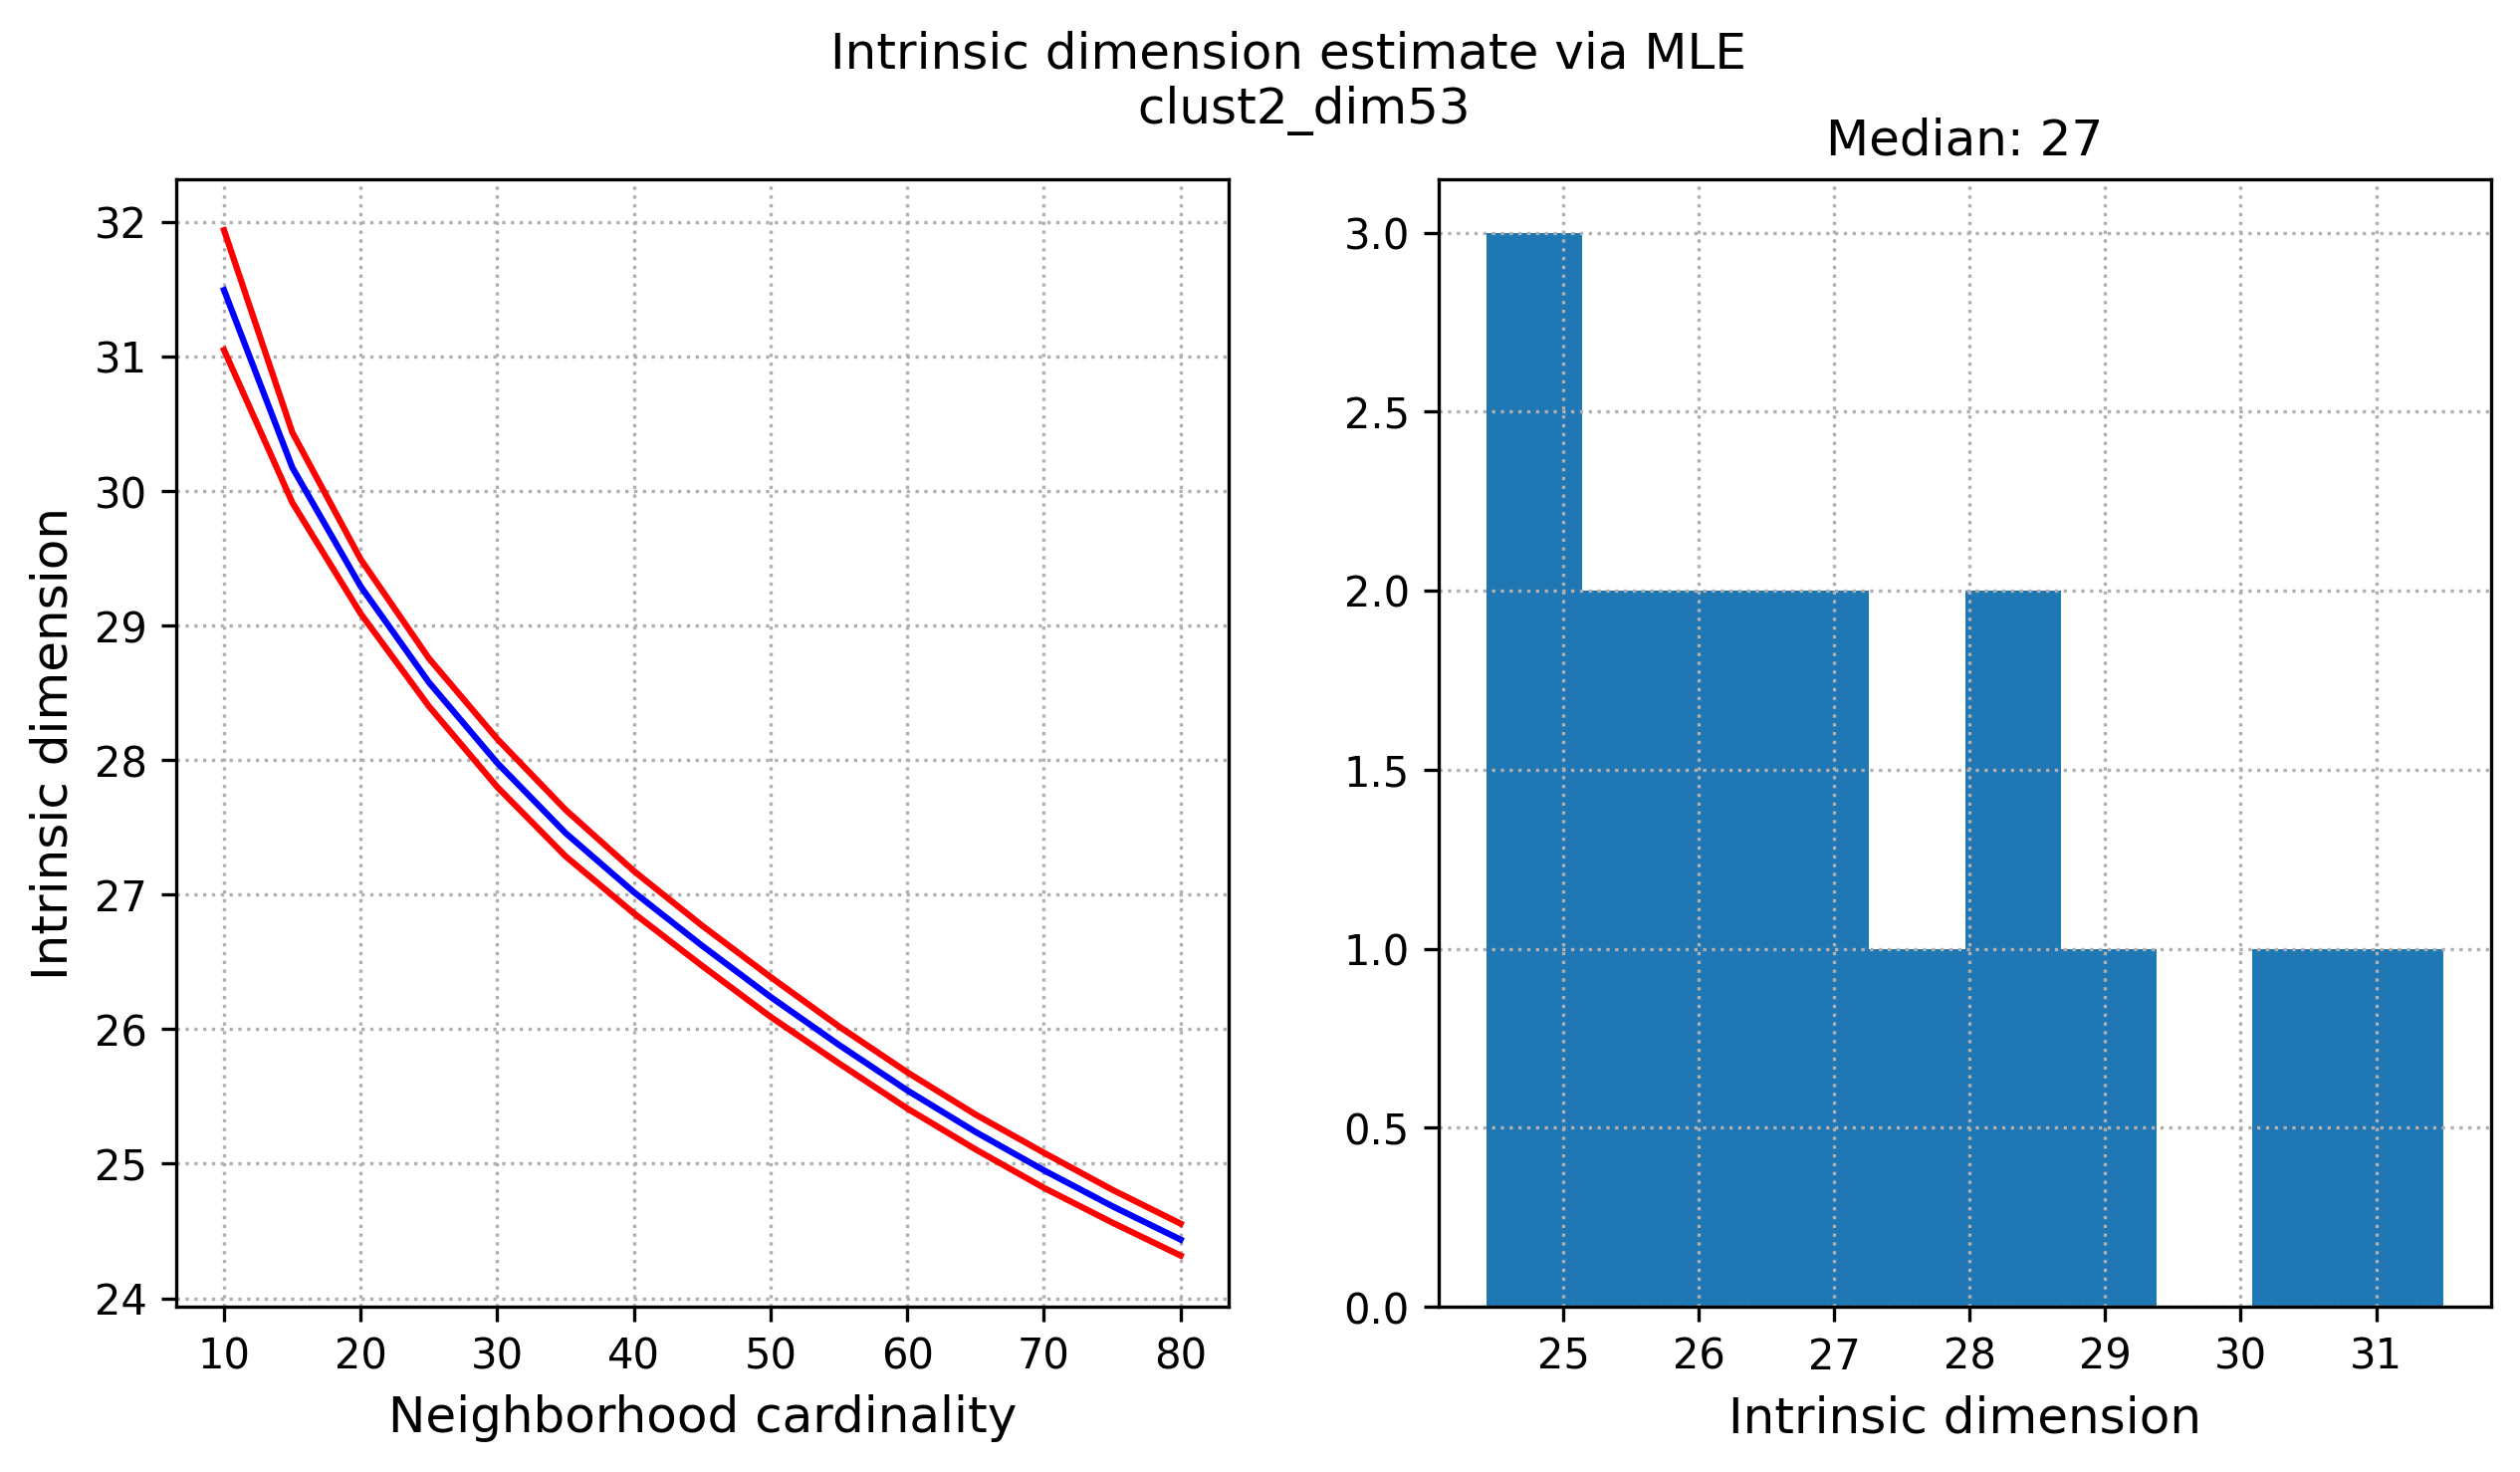

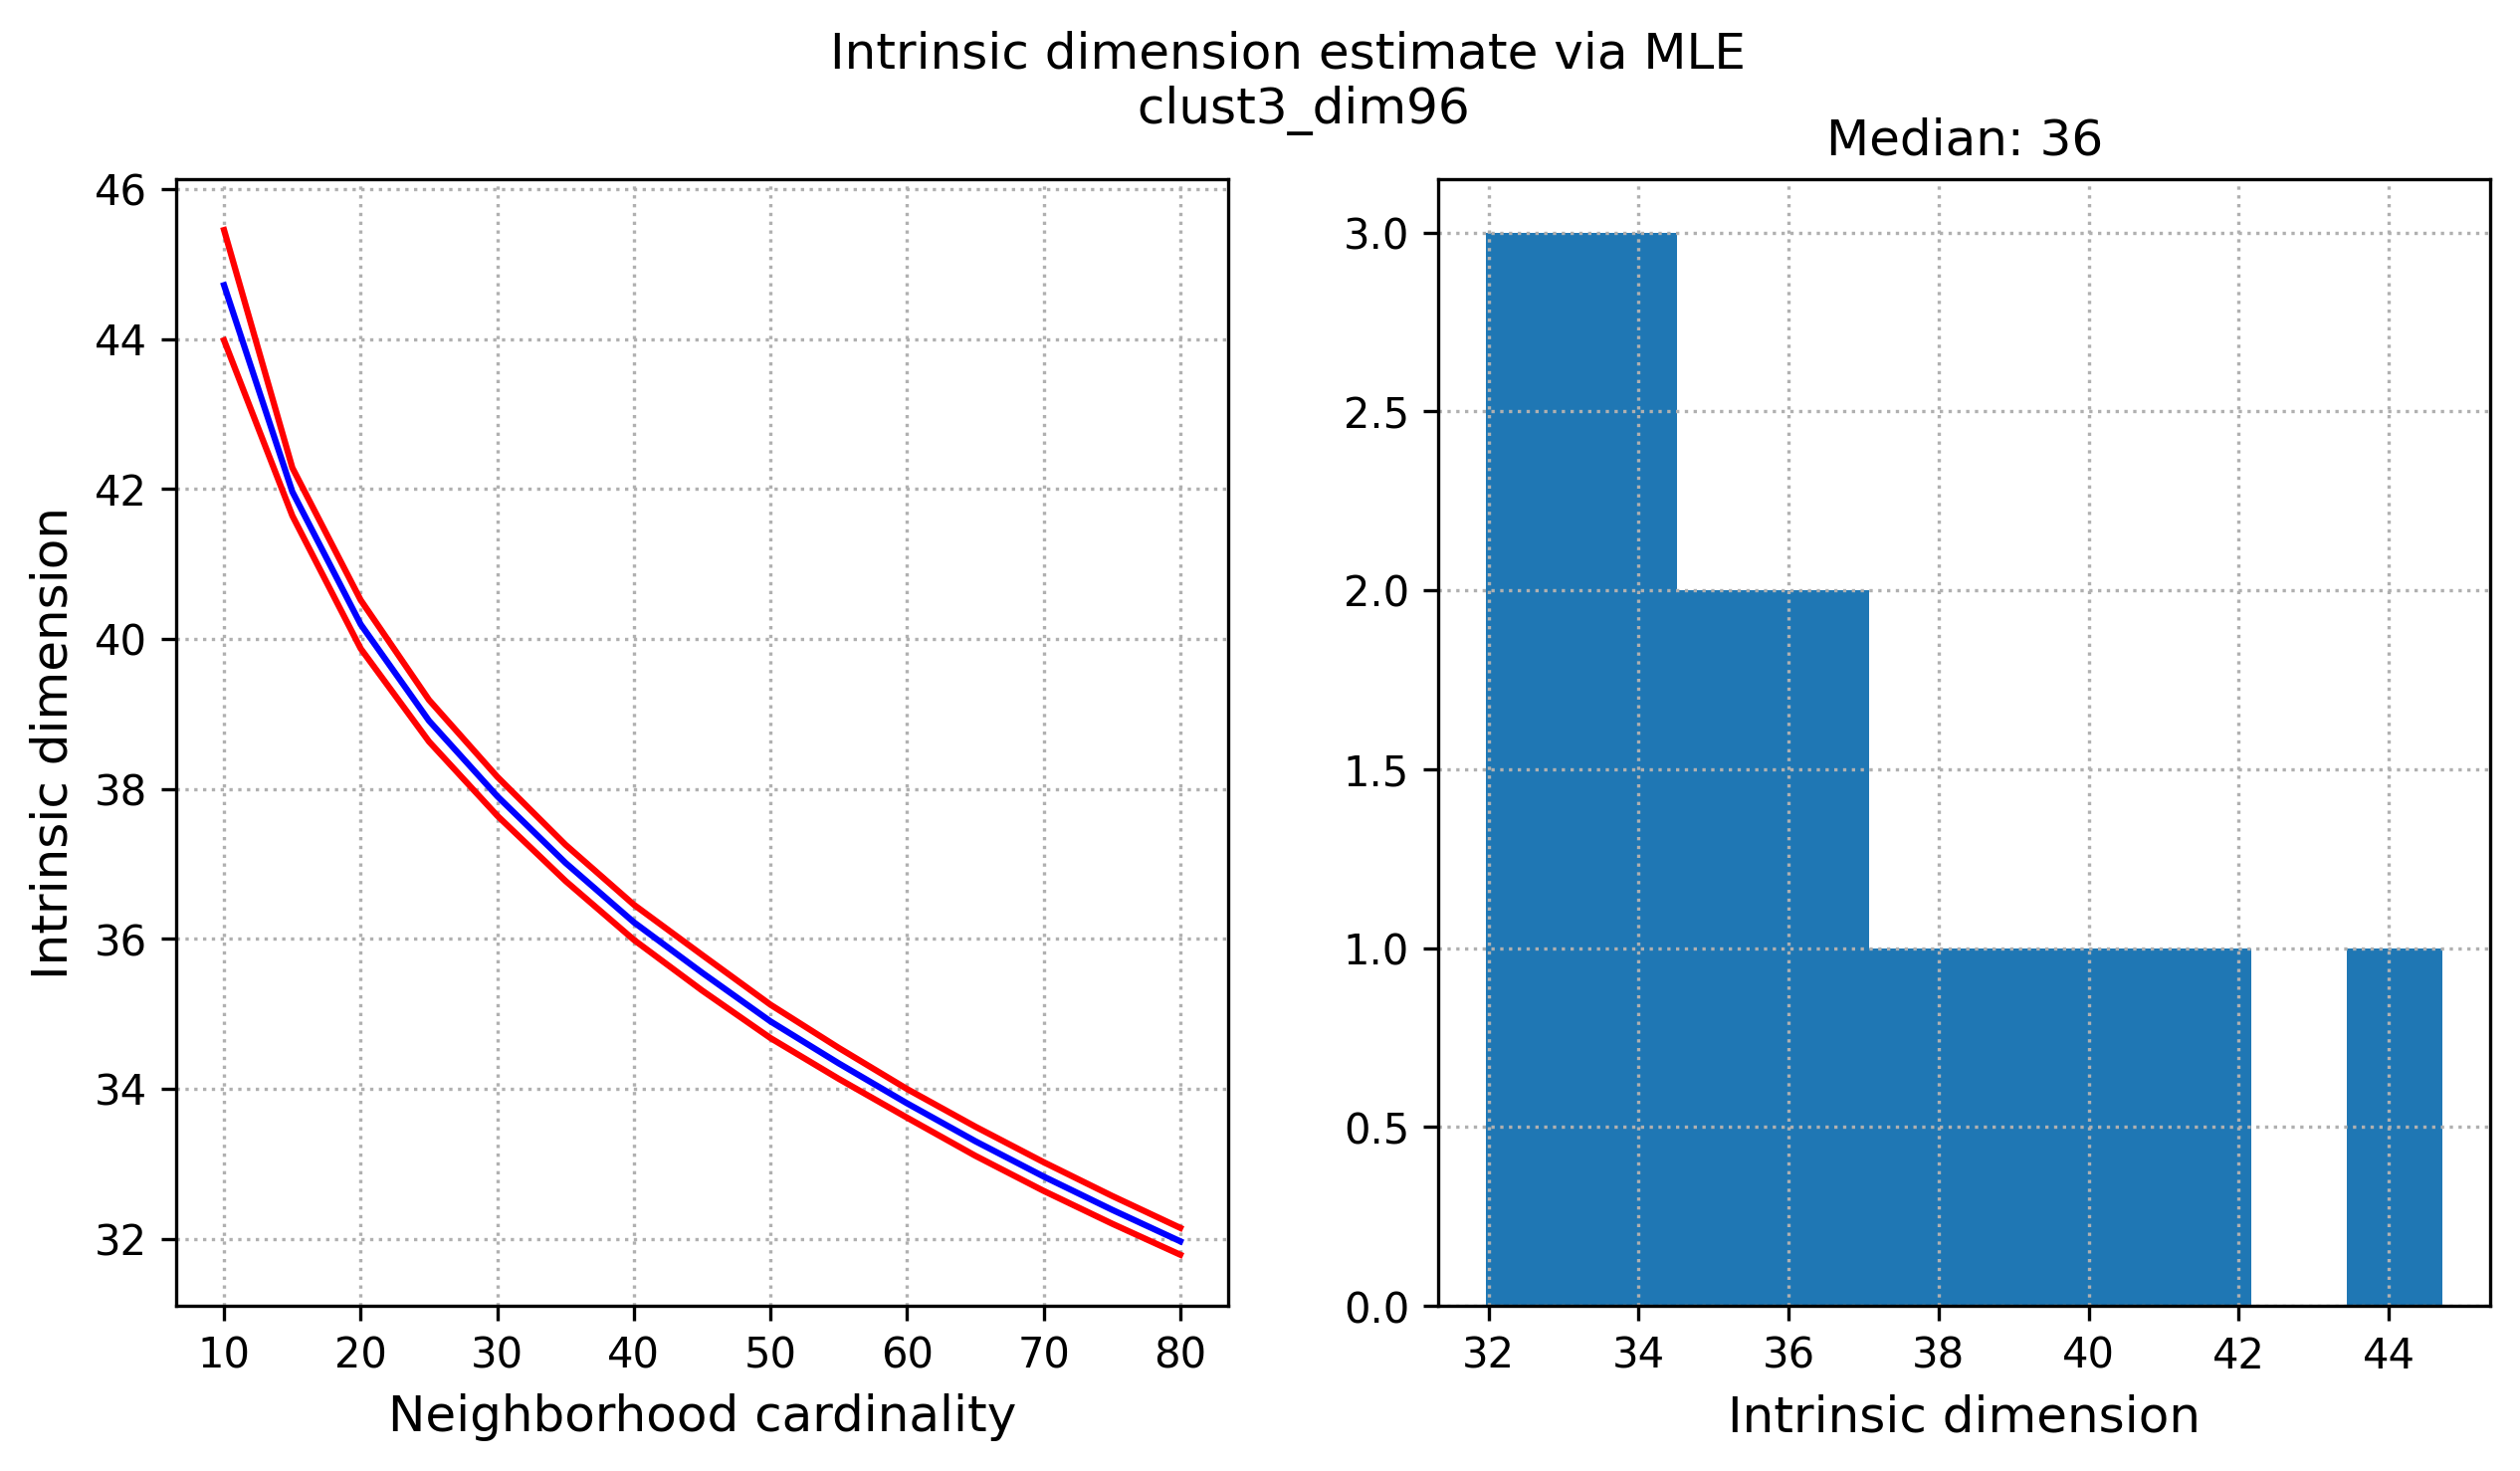

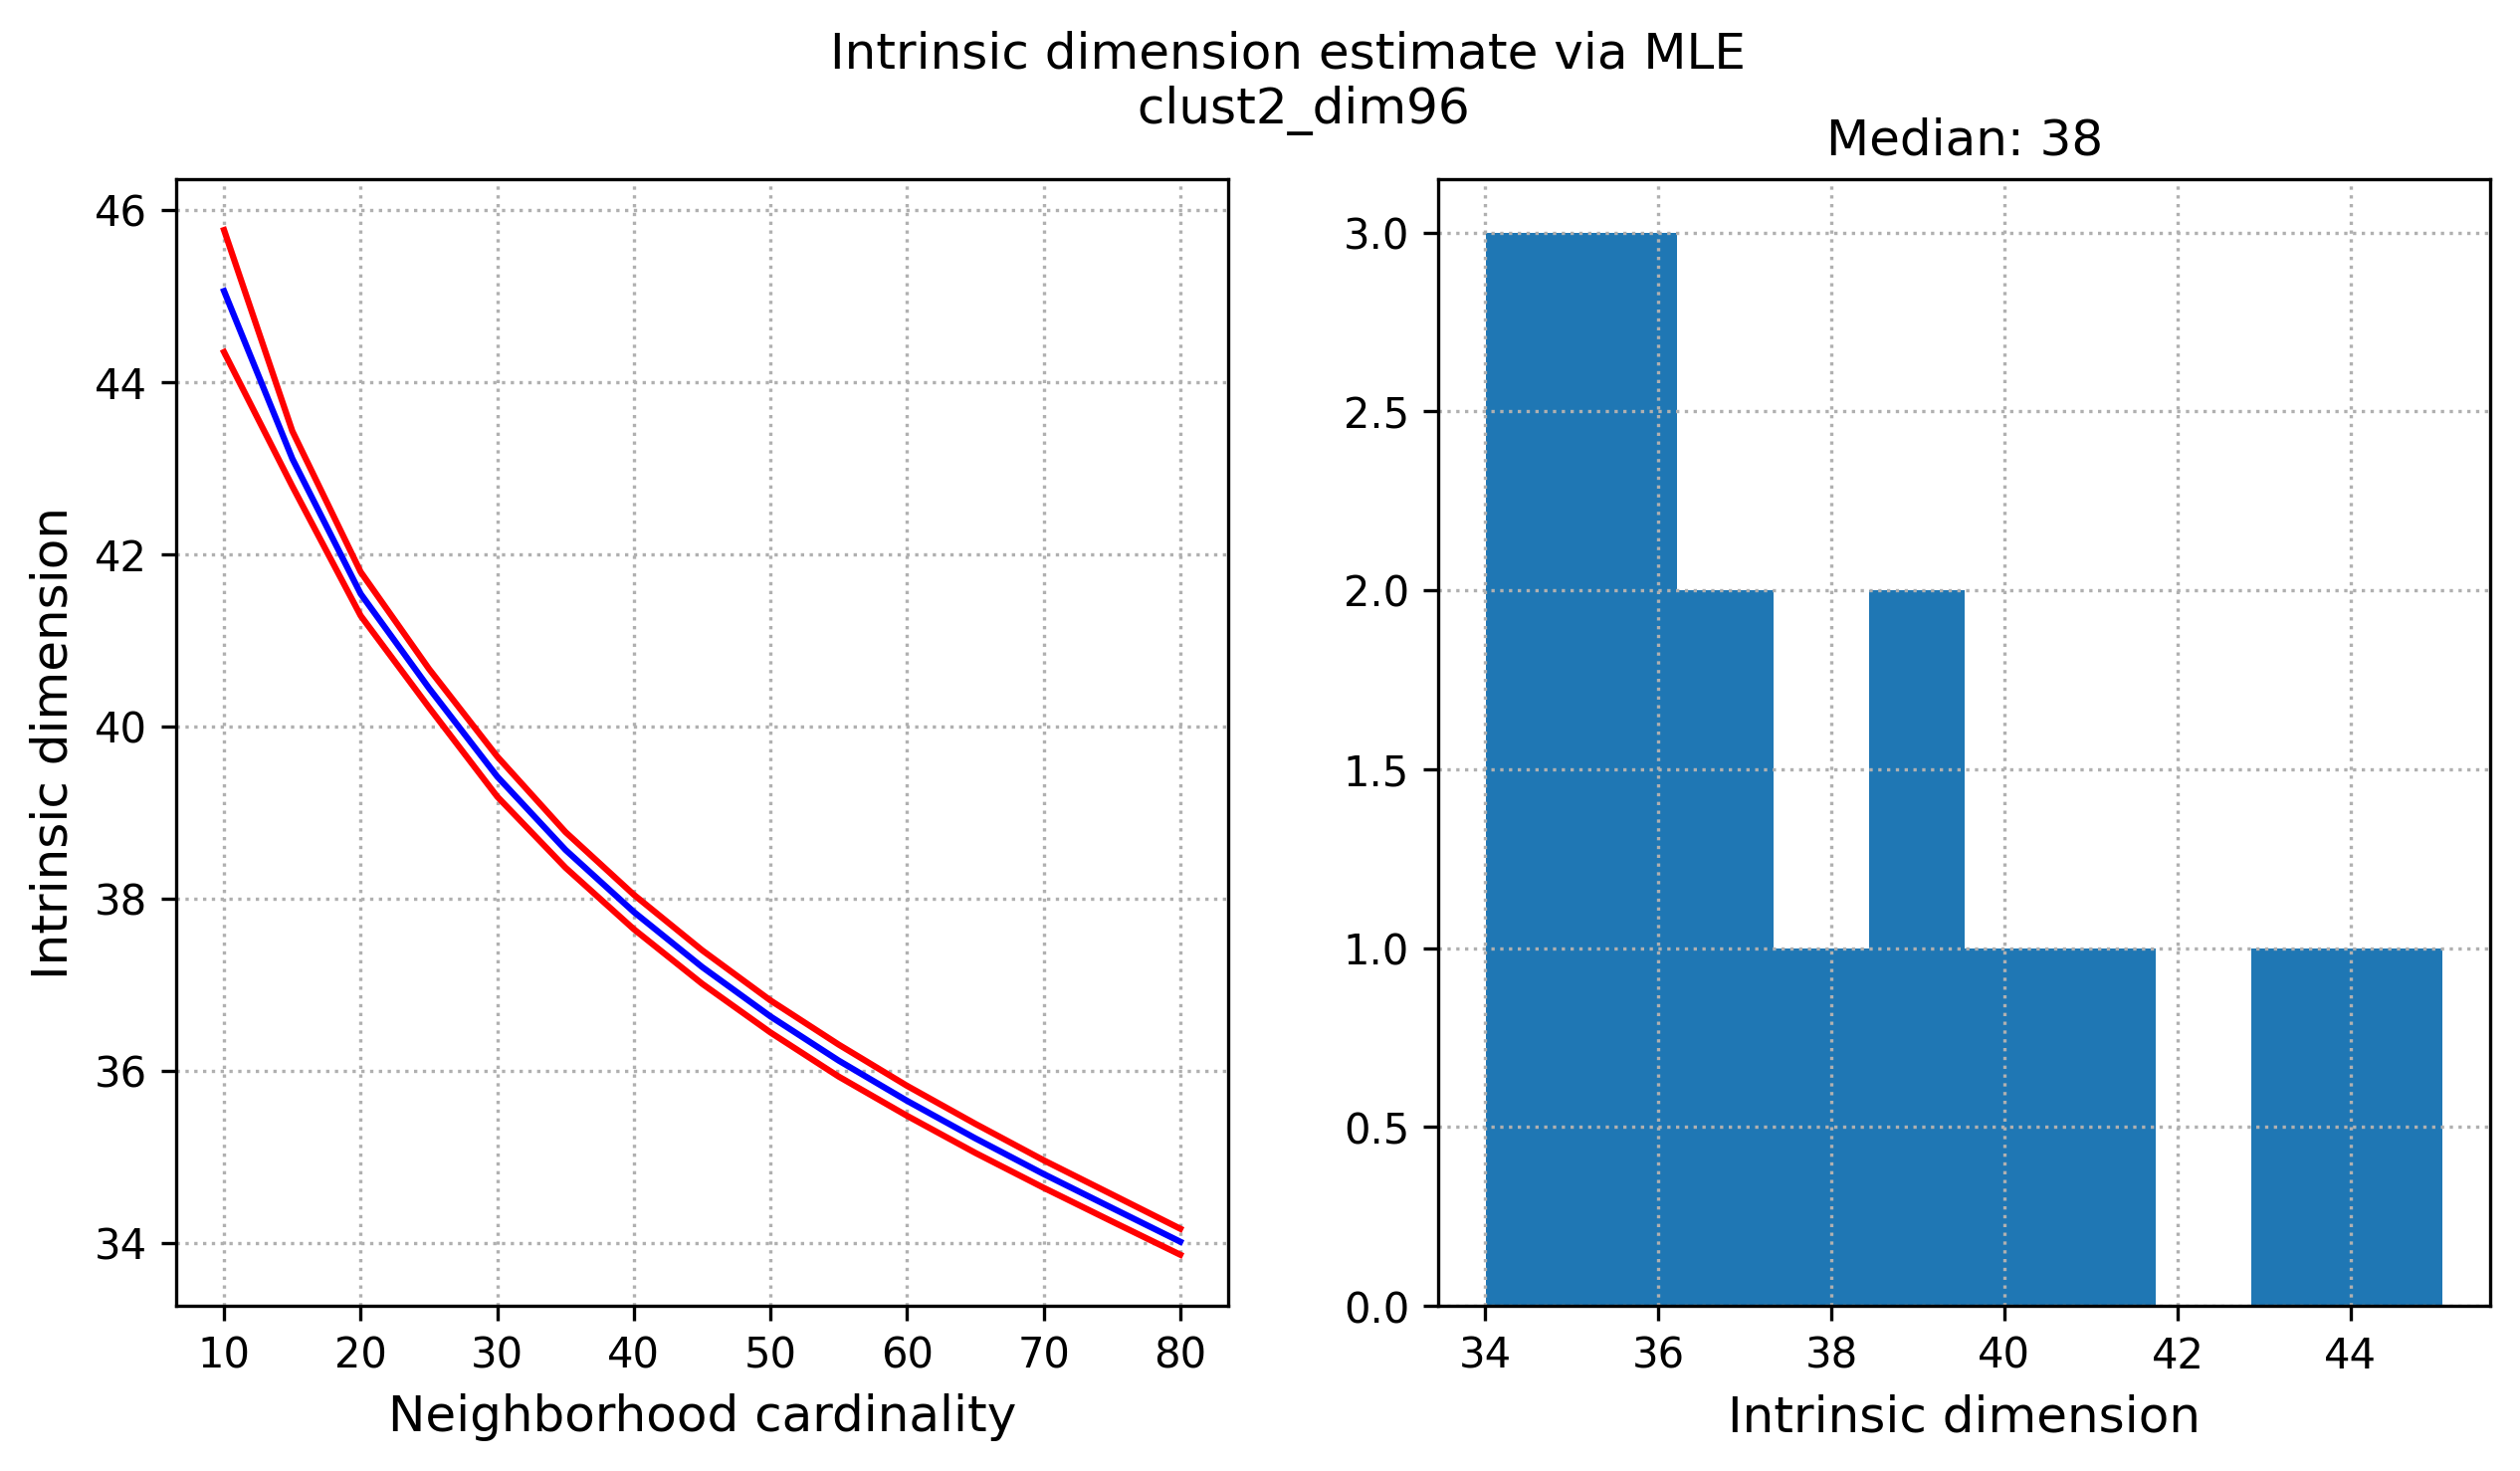

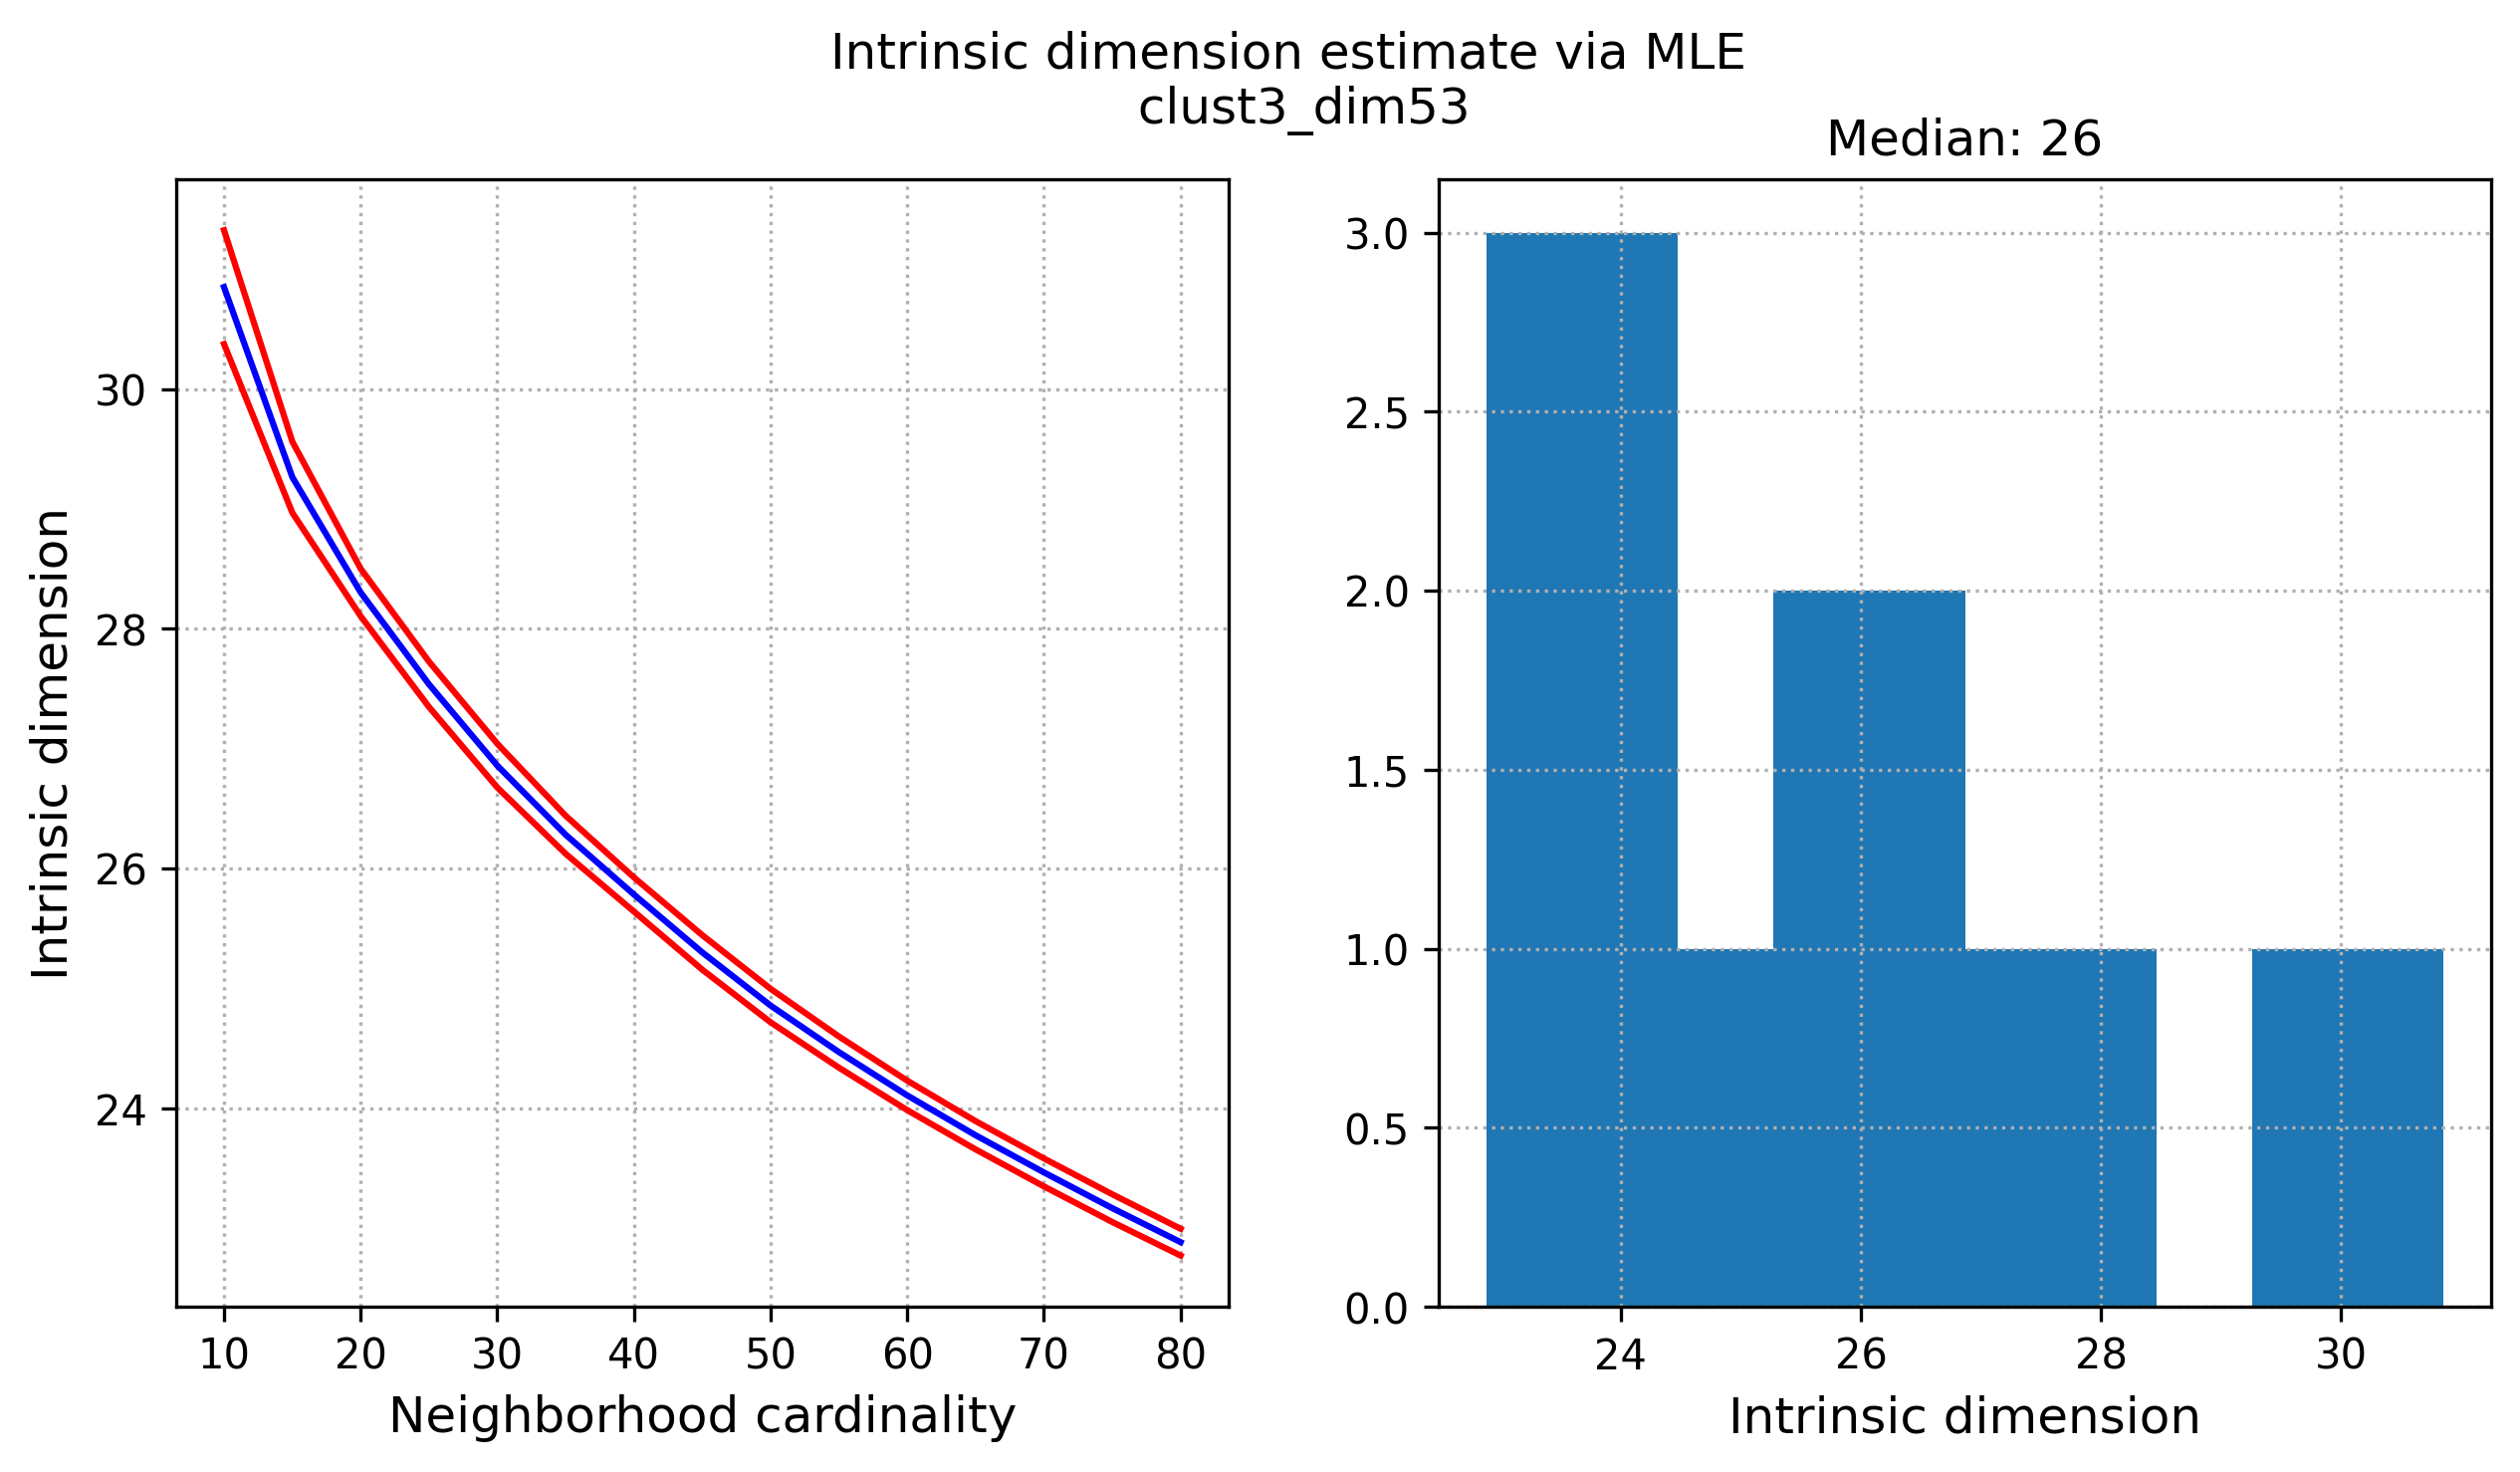

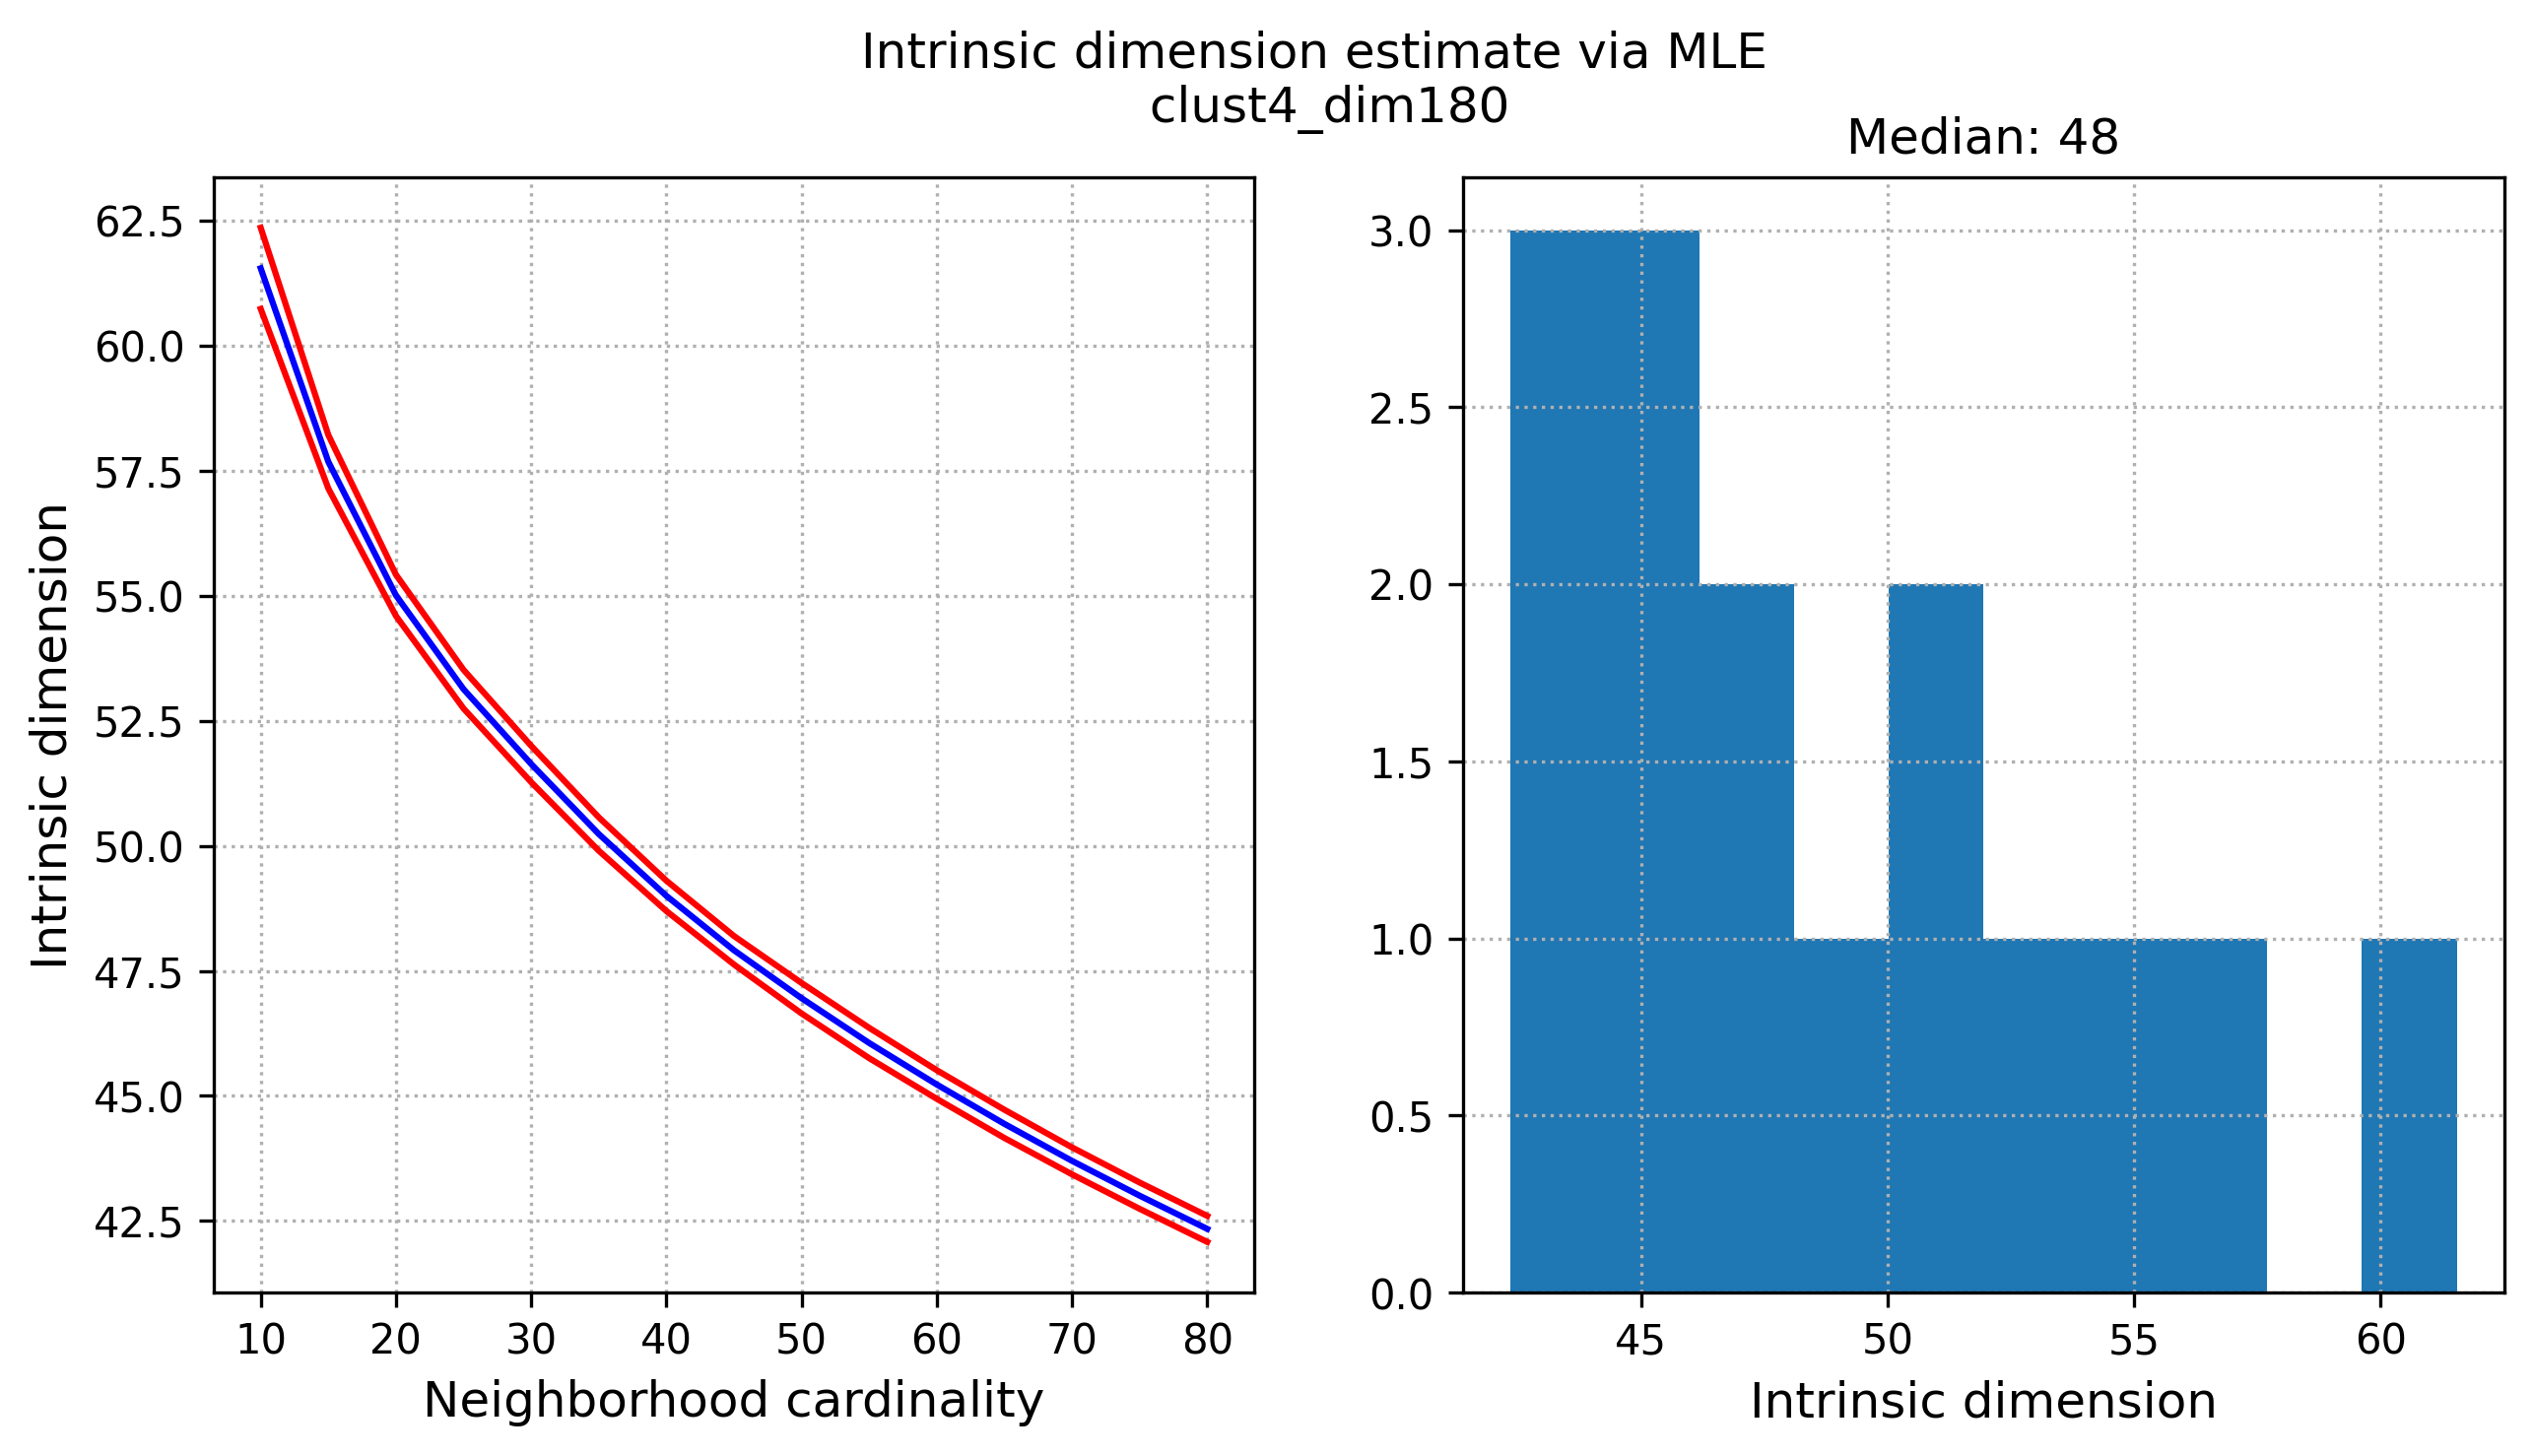

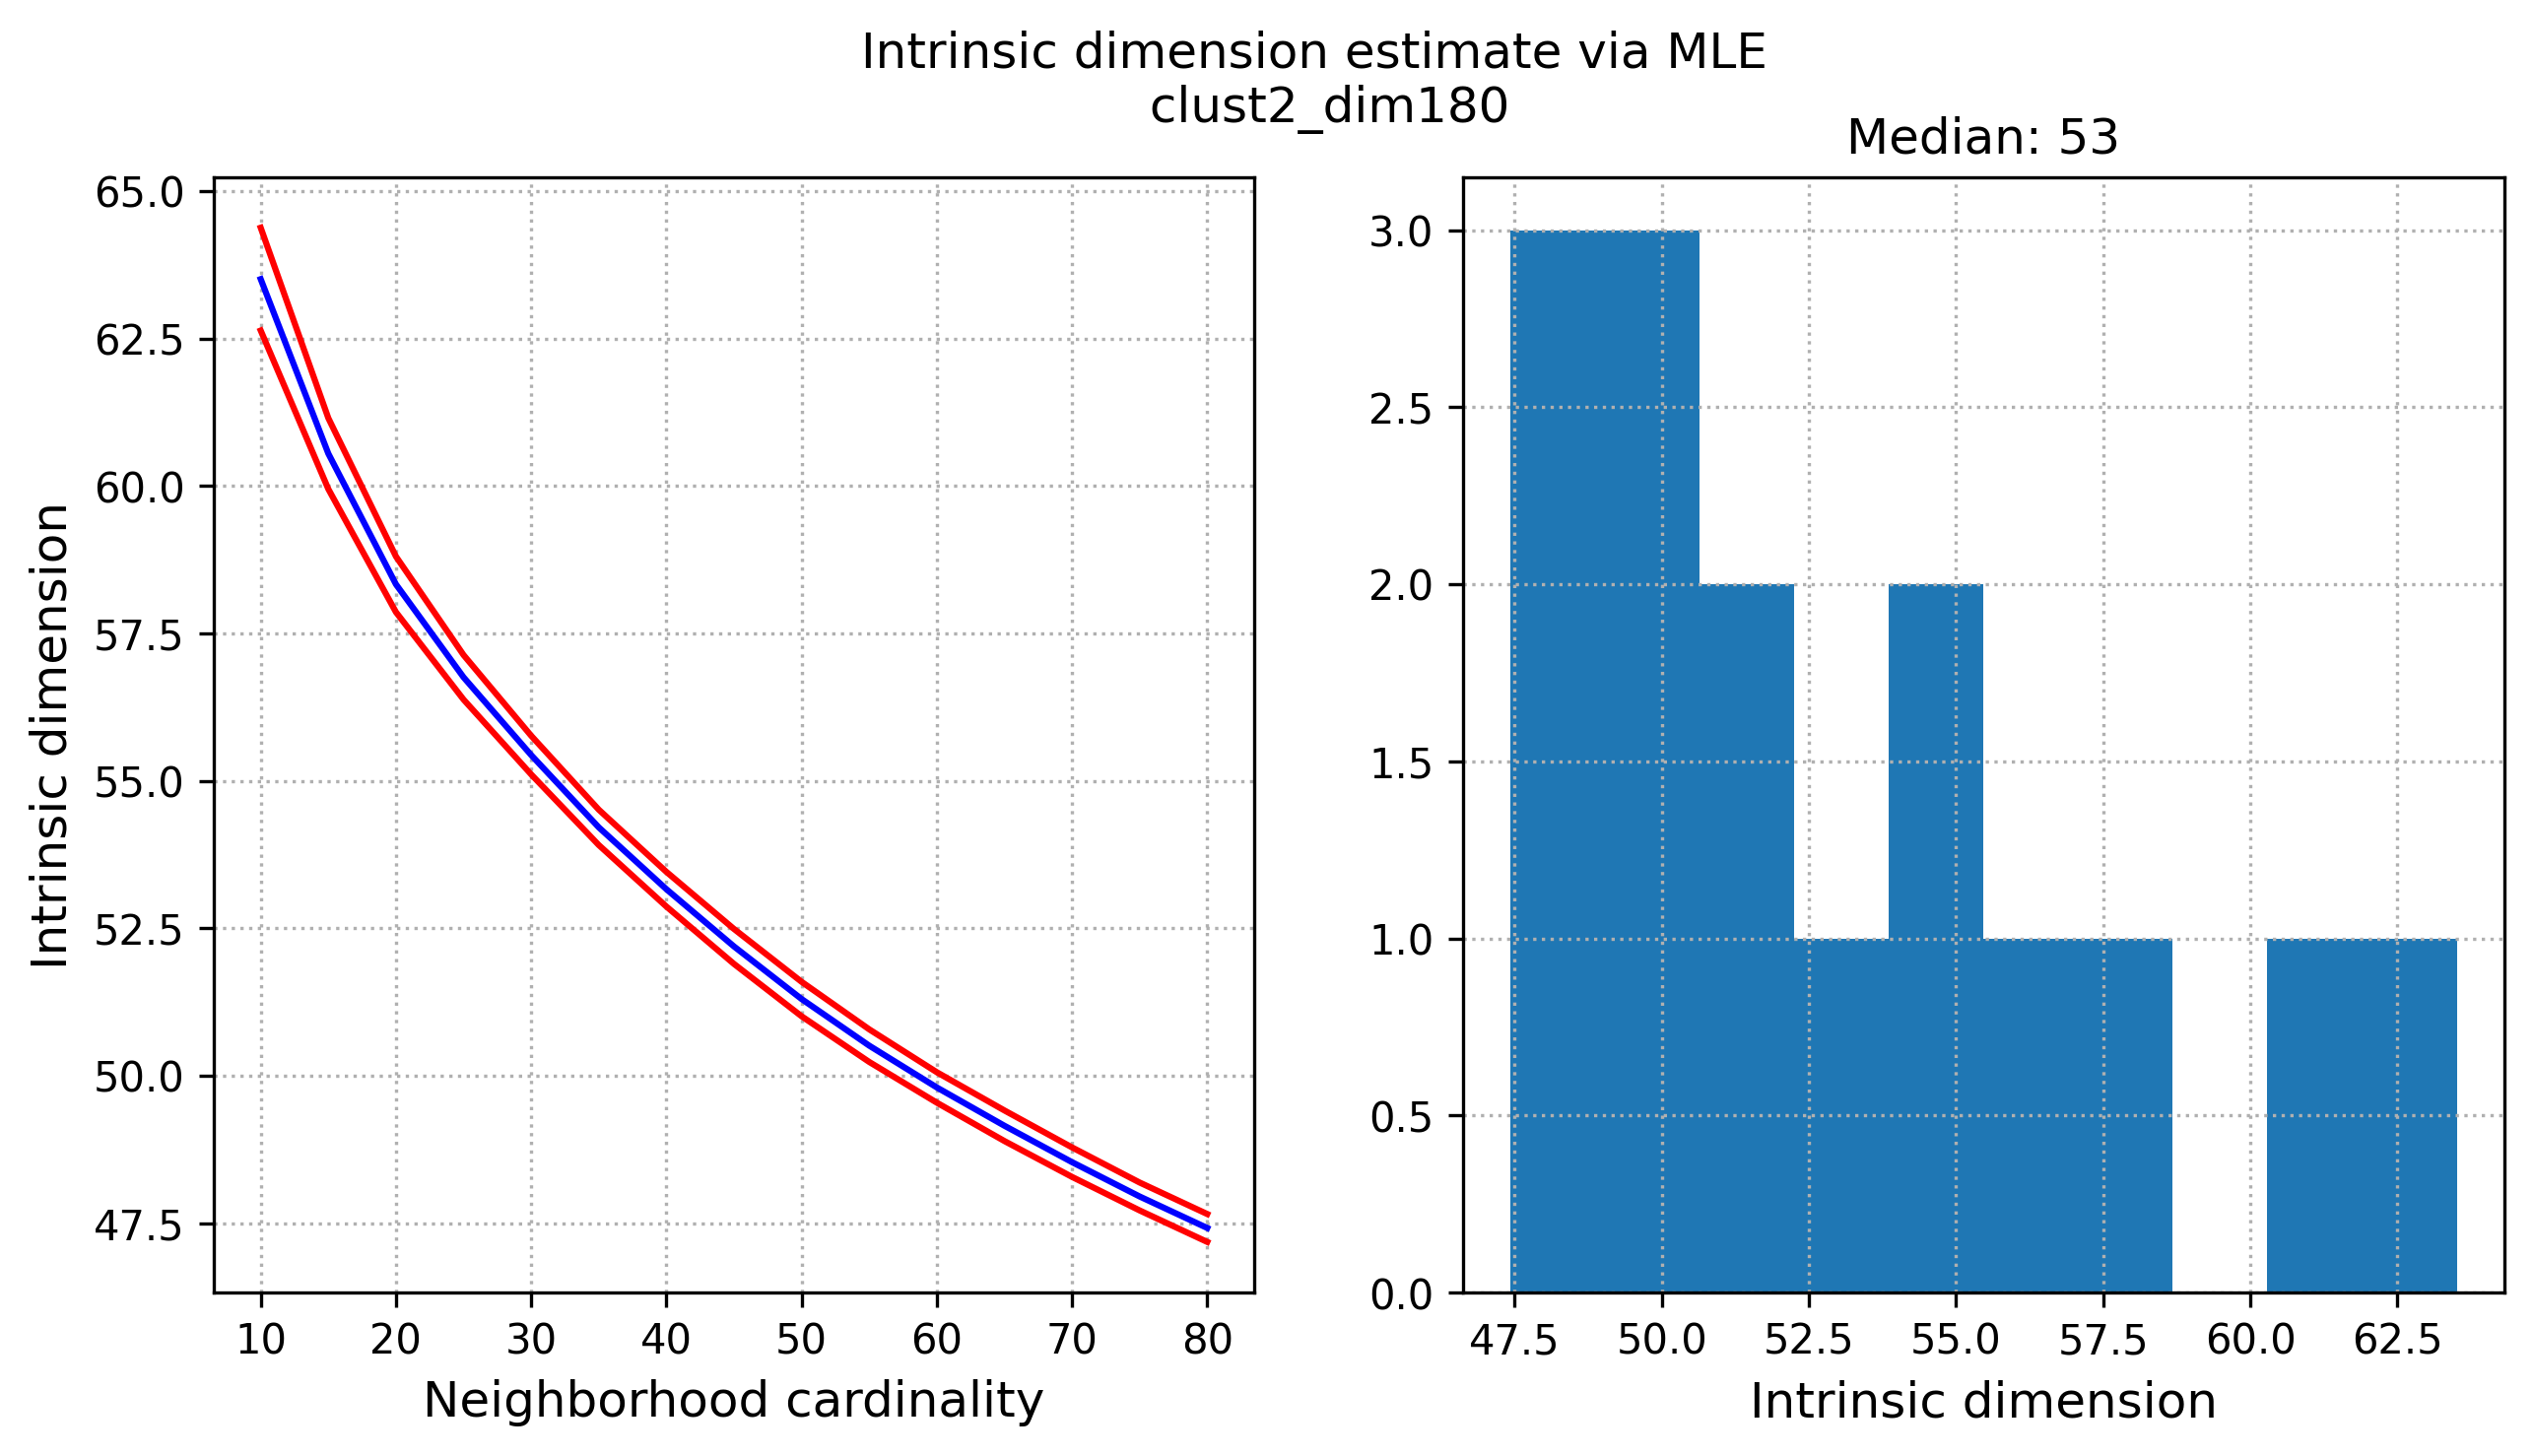

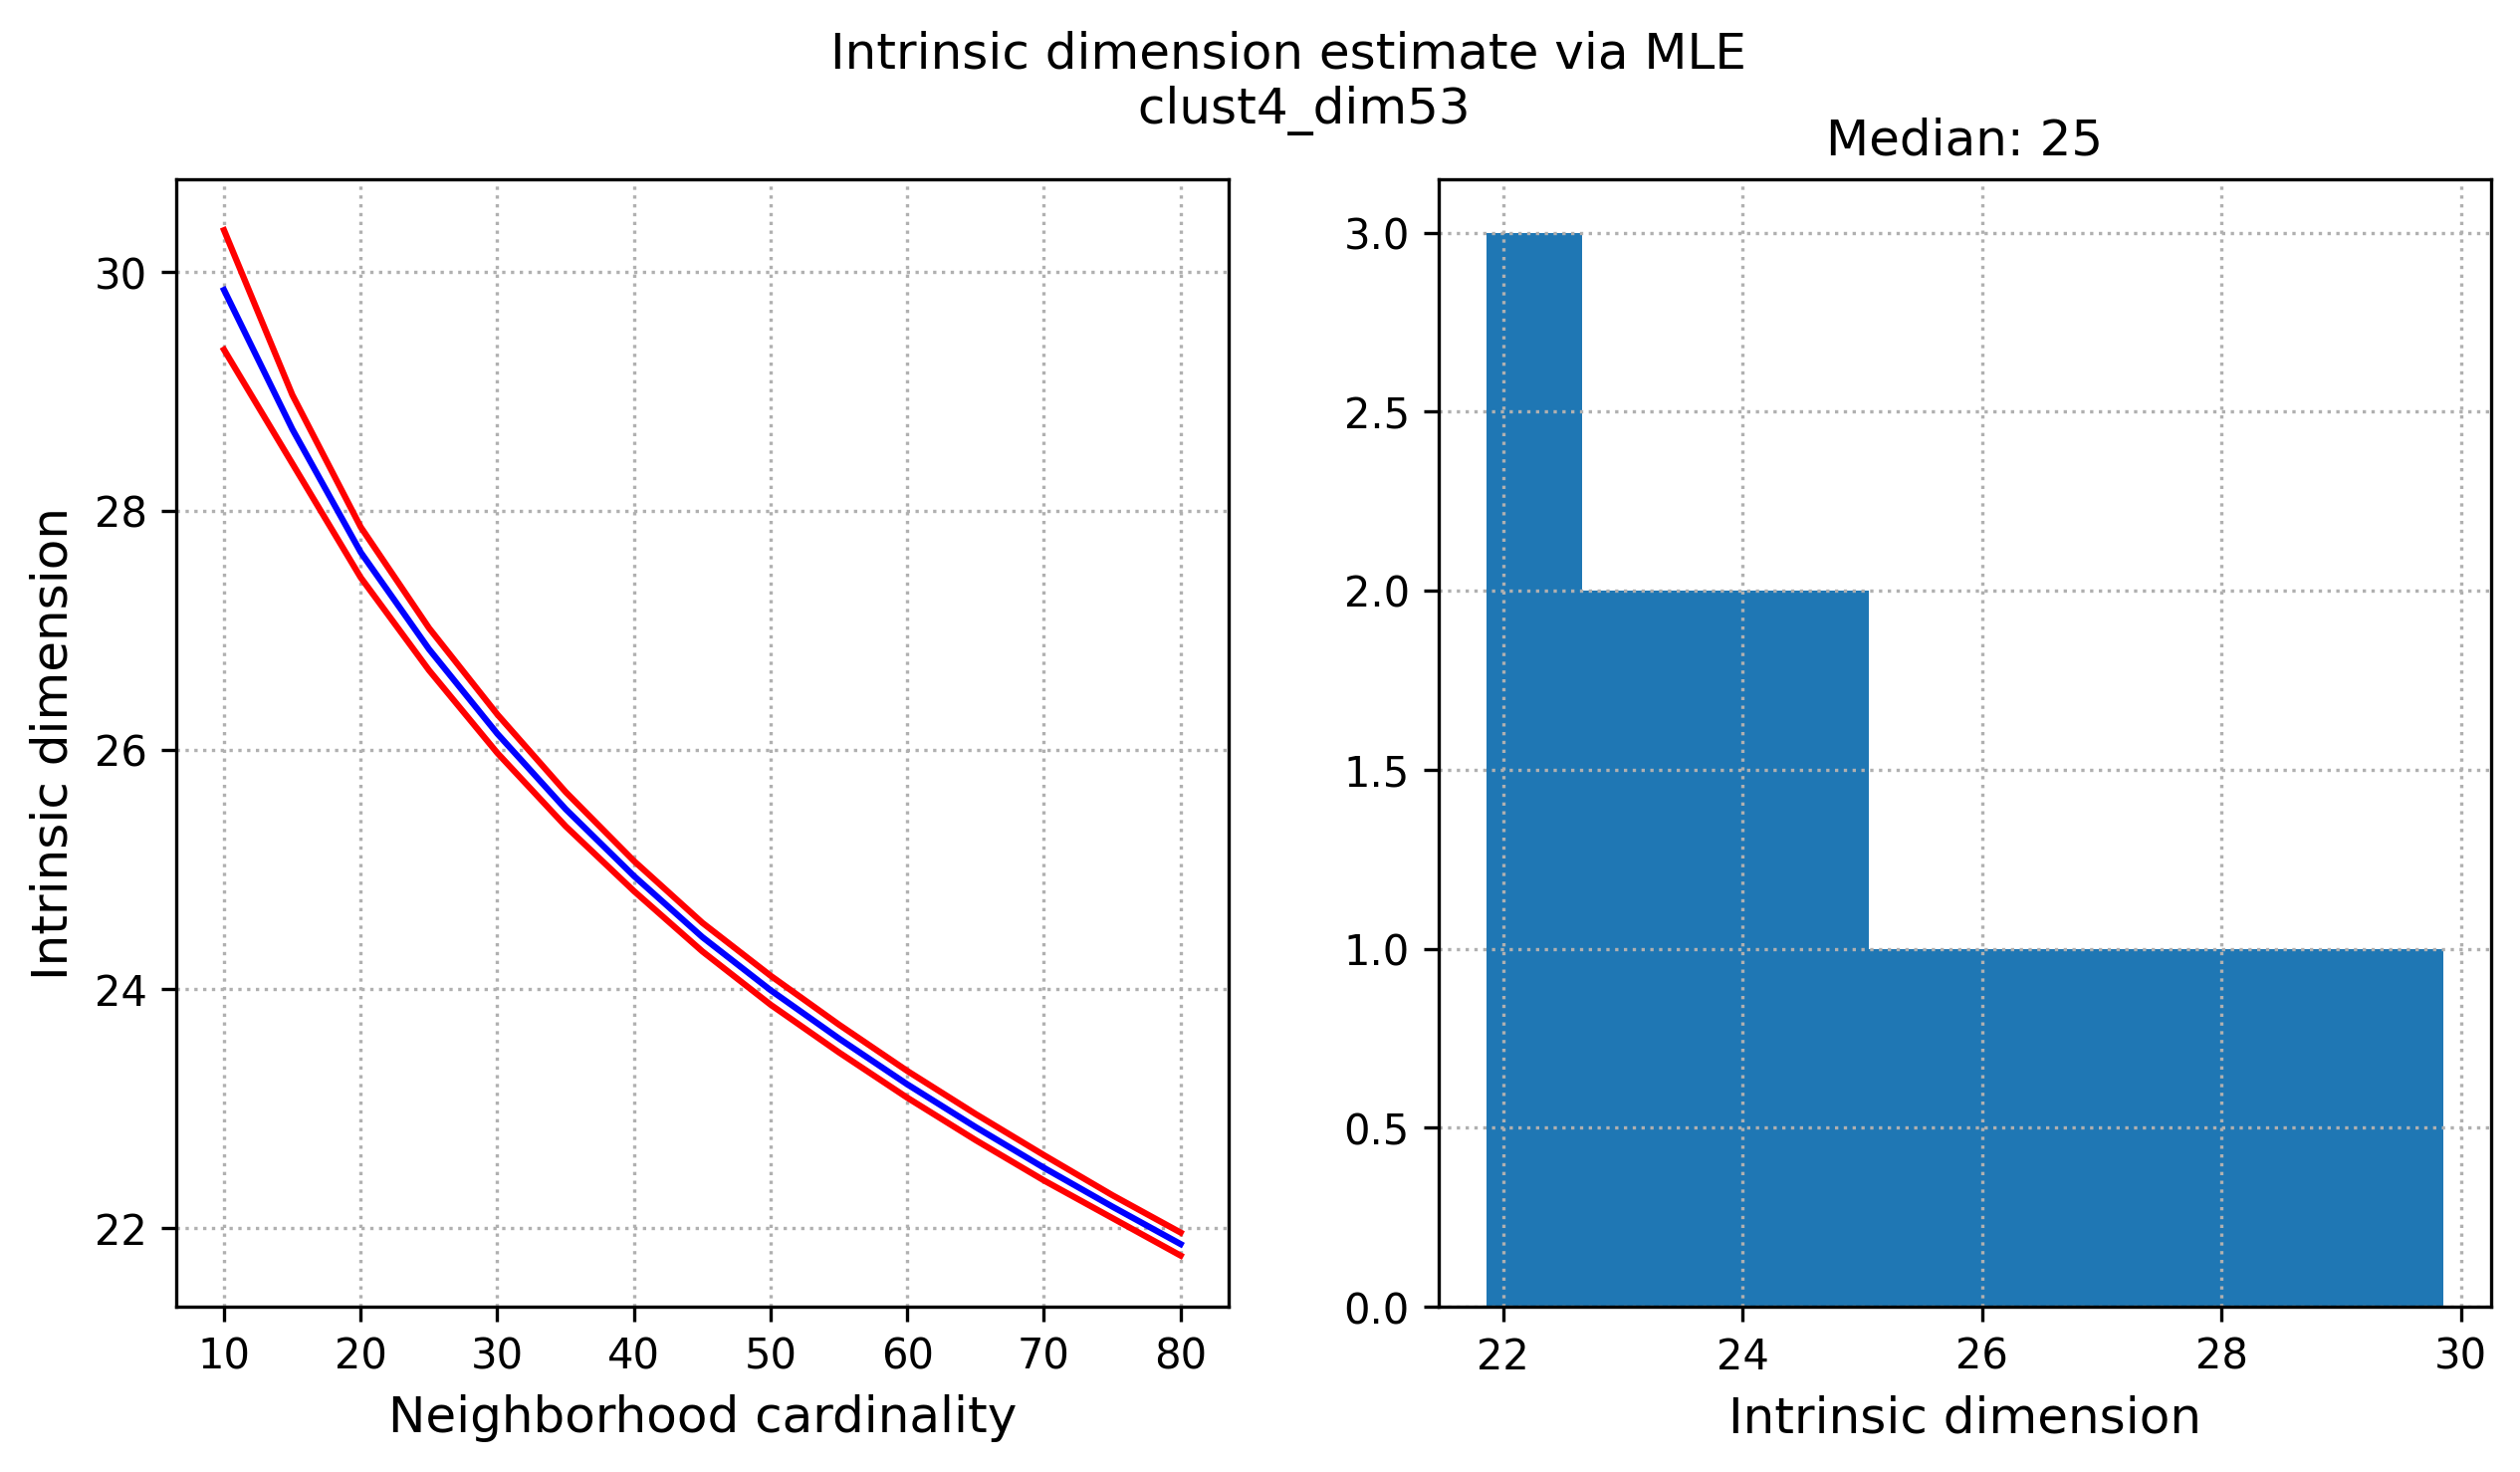

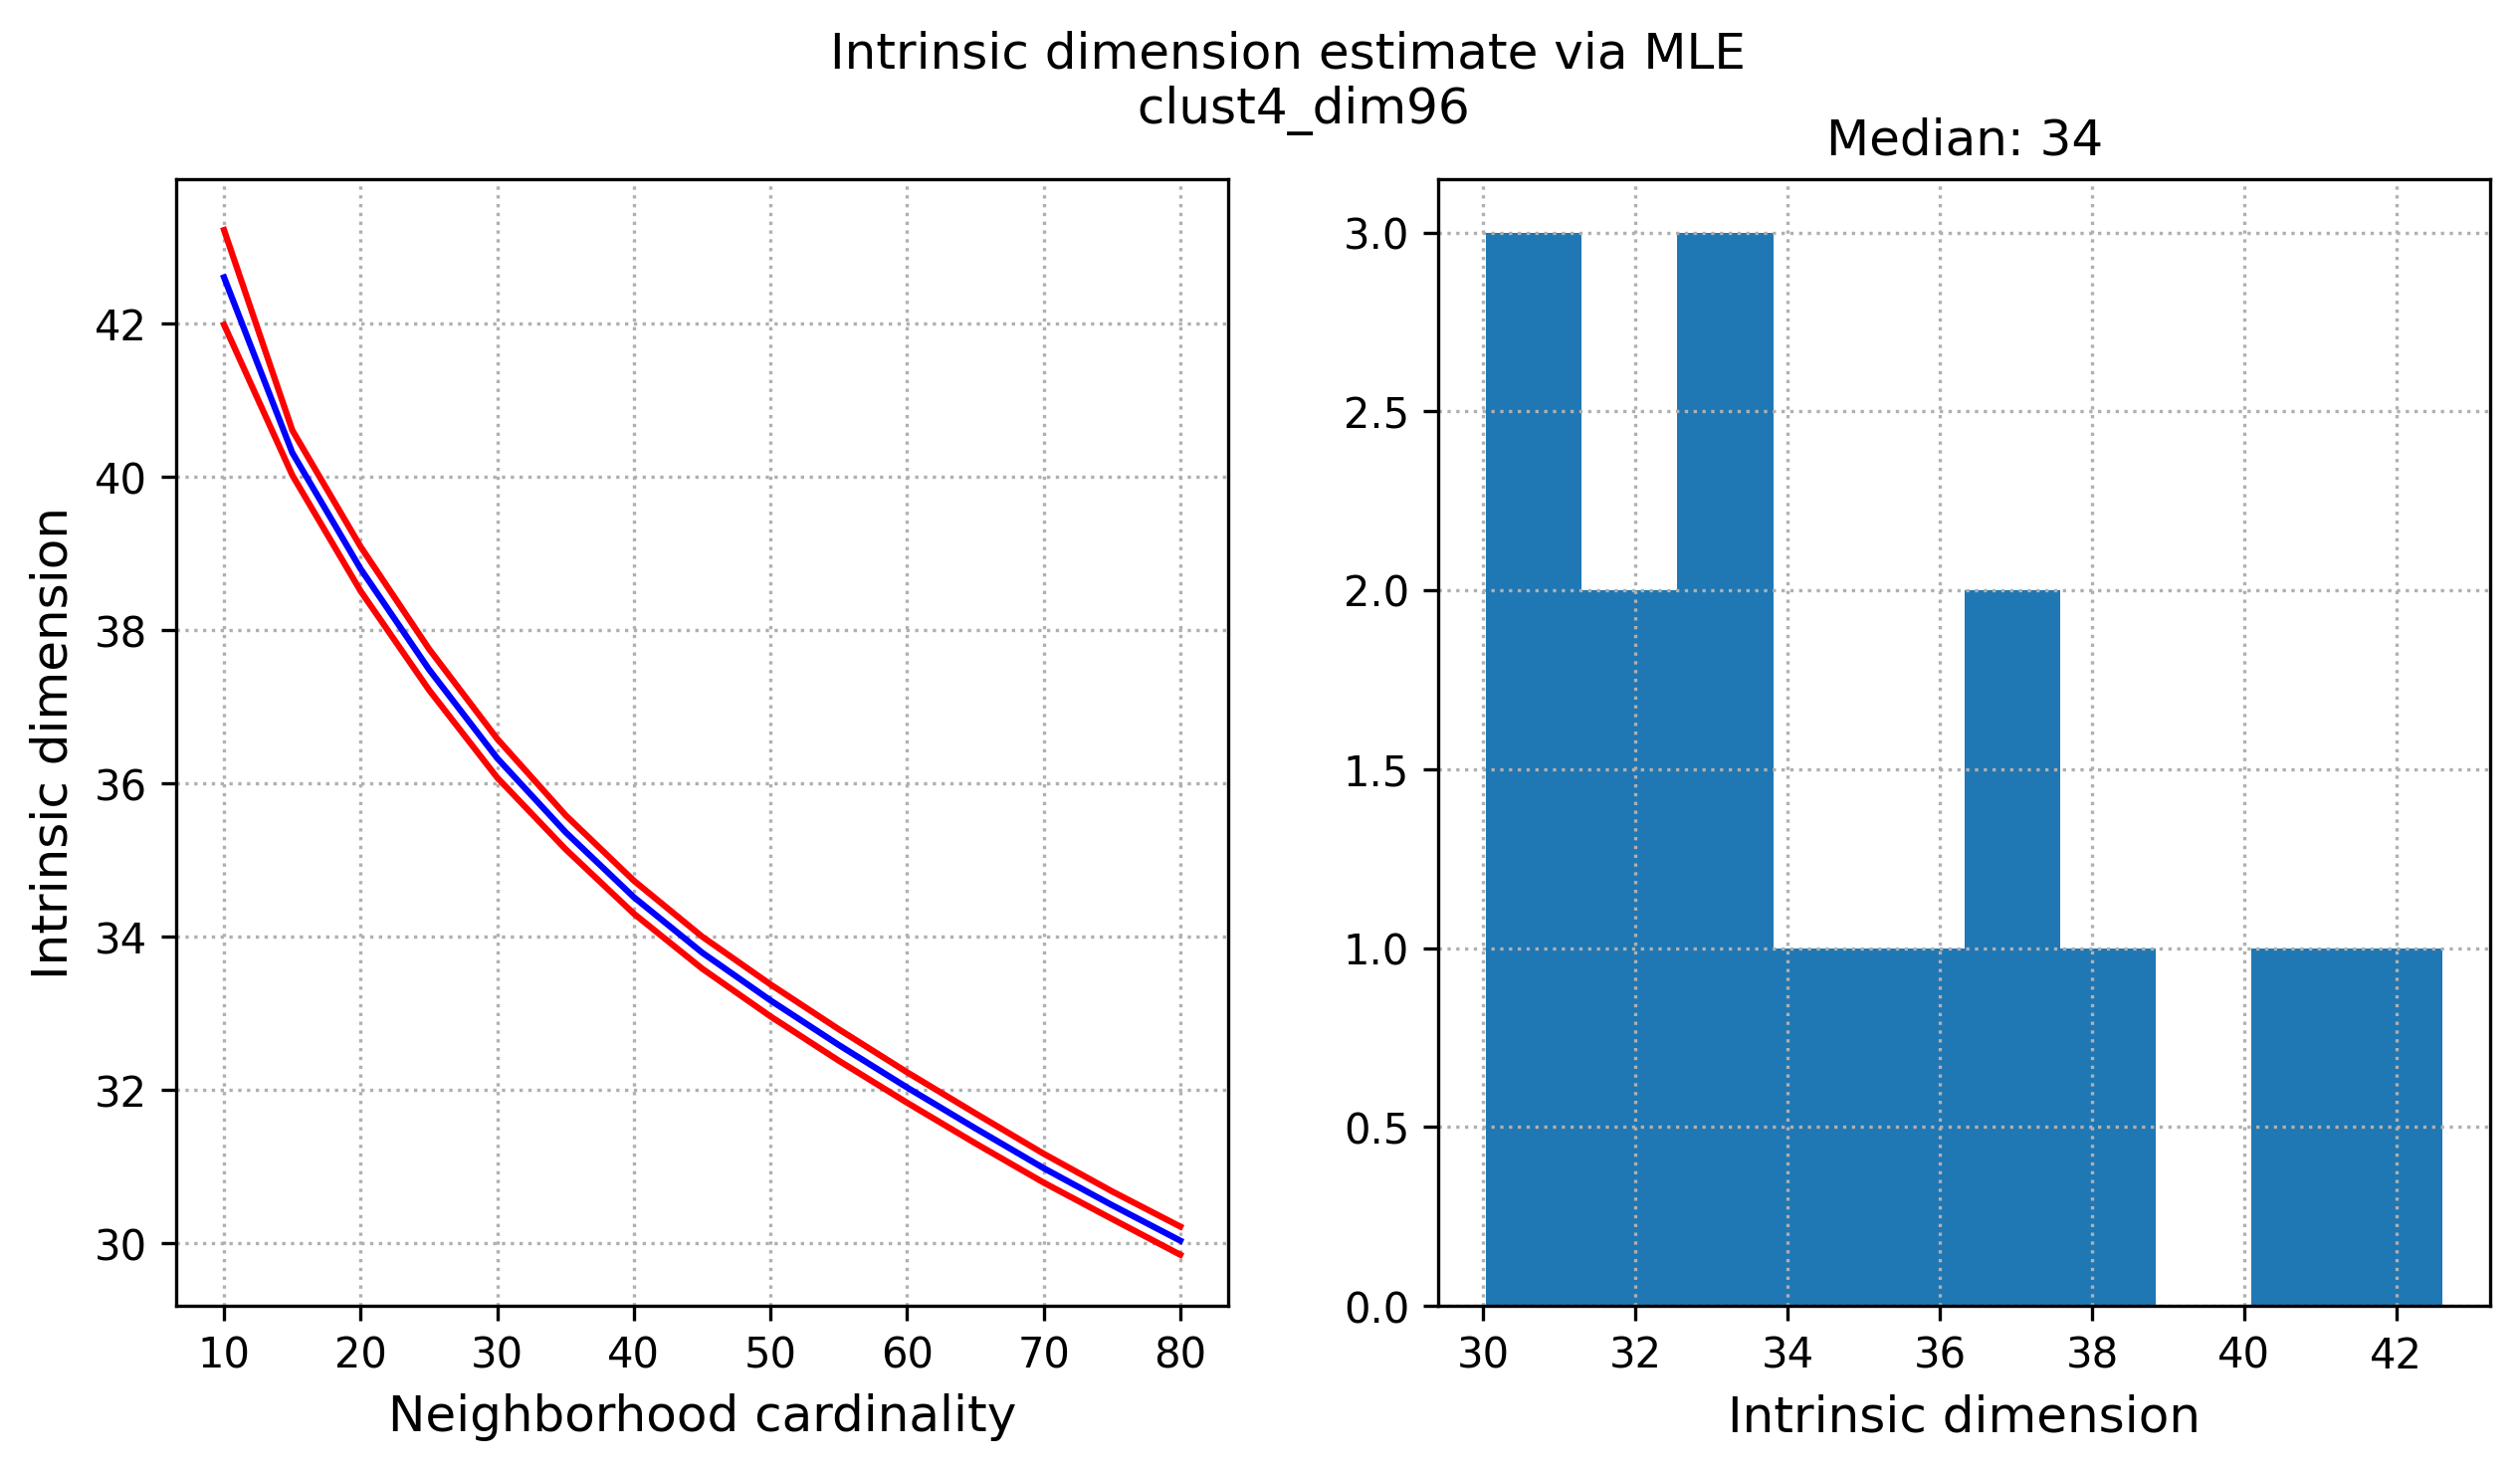

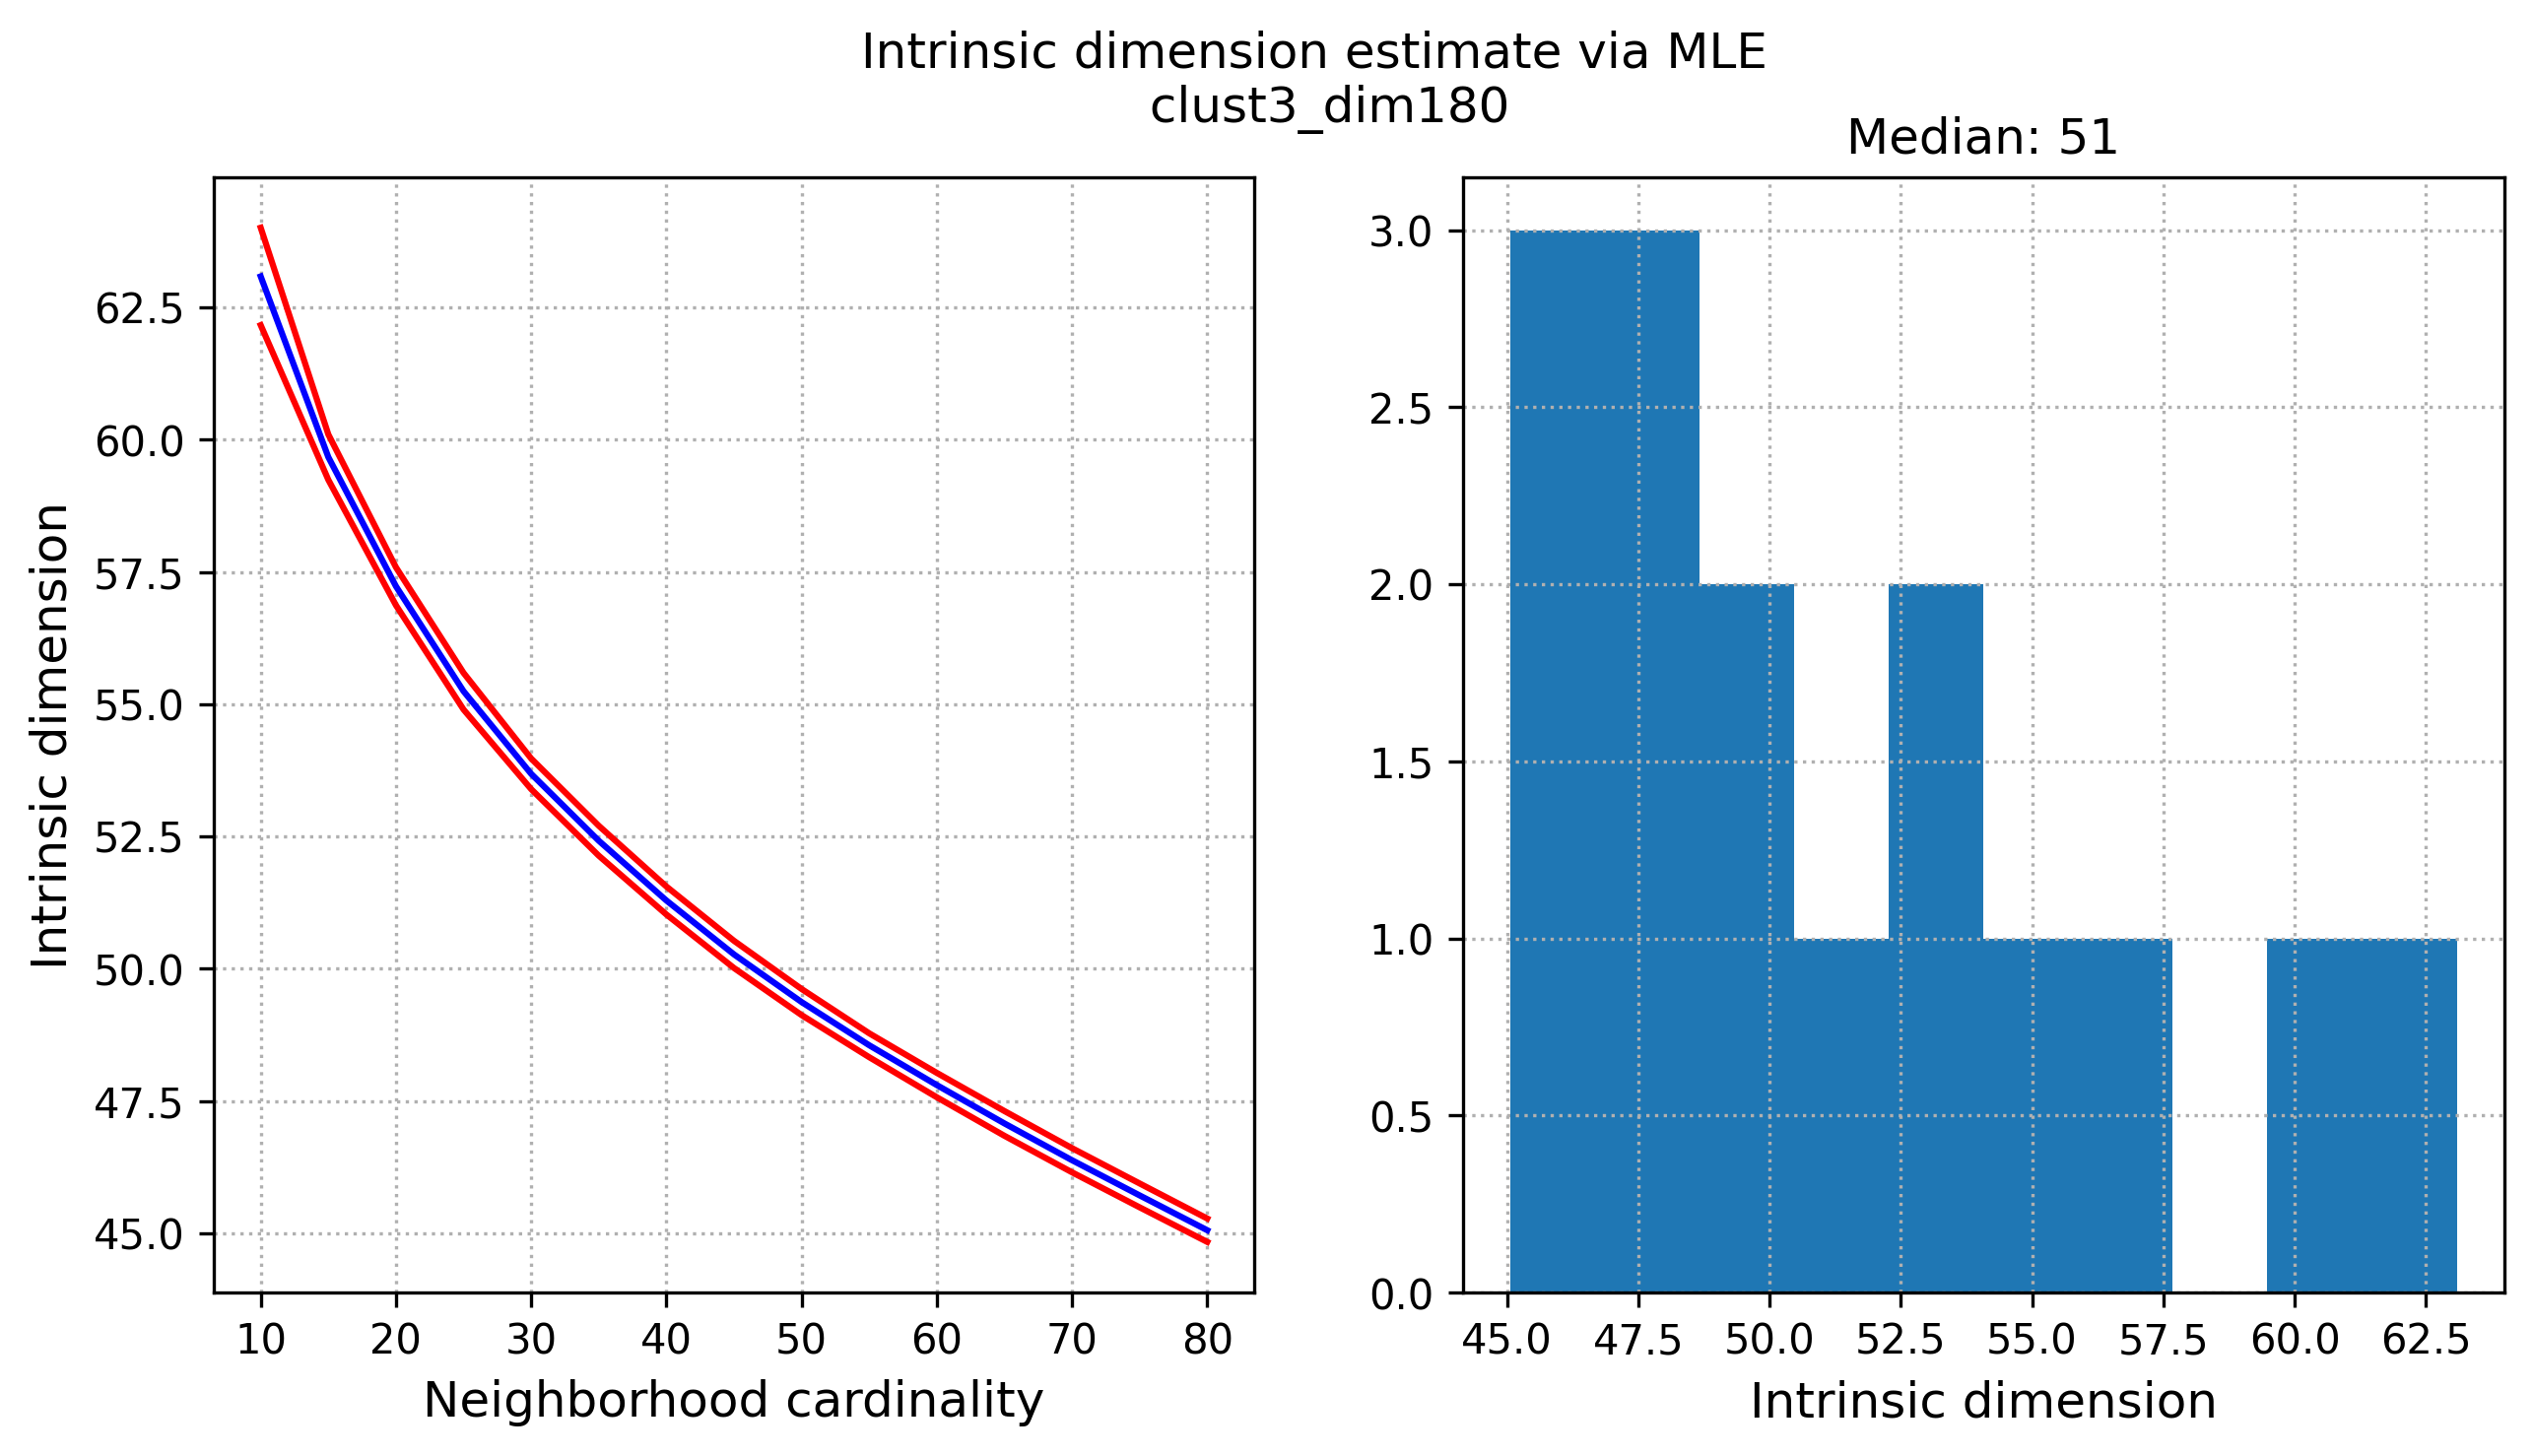

In [18]:
intrinsic_dims_med = {}
for label, intdim_k_repeated in indims.items():
    
    fig = plt.figure(figsize=(10,5), dpi=300)
    plt.suptitle(f"Intrinsic dimension estimate via MLE \n {label}", fontsize=12)
    
    floor_n_ceil = np.concatenate((np.floor(np.mean(intdim_k_repeated, axis=0)).astype(int), 
                                    np.ceil(np.mean(intdim_k_repeated, axis=0)).astype(int)))
    
    plt.subplot(121)
    plt.xlabel("Neighborhood cardinality", fontsize=12)
    plt.ylabel("Intrinsic dimension", fontsize=12)
    plt.grid(linestyle='dotted')

    plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10,\
             np.mean(intdim_k_repeated, axis=0), 'b')
    plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10,\
             np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
    plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10,\
             np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

    plt.subplot(122)
    plt.xlabel("Intrinsic dimension", fontsize=12)
    plt.grid(linestyle="dotted")

    plt.hist(intdim_k_repeated.mean(axis=0))
    med = int(np.ceil(np.percentile(intdim_k_repeated.mean(axis=0),50)))
    plt.title(f'Median: {med}')
    intrinsic_dims_med[label] = med
    plt.show()

In [20]:
# # uncomment for synthetic data
# np.save('./intrinsic_dims_pca_strict_synthetic', intrinsic_dims_med)

In [28]:
intrinsic_dims_strict = {'AGP_o':5, 
                        'AGP_f':8,
                        'AGP_g':9, 
                        'HMP_o':5,
                        'HMP_f':6,
                        'HMP_g':7}

In [29]:
np.save('./intrinsic_dims_pca_strict', intrinsic_dims_strict)